<a href="https://colab.research.google.com/github/xslittlemaggie/Tencent_Education_Deep_Learning_Course/blob/master/bikes_prediction_Time_Series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [0]:
import pandas as pd
import numpy as np
import time
# visualization
import matplotlib.pyplot as plt

# model building
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, SimpleRNN

# 1. 数据导入， 输入处理

## 读取数据

In [0]:
data = pd.read_csv("http://resuly.me/data/bike_rnn.csv")

In [5]:
data.head(10)

,num,weekday,hour
0,0,5,17
1,1,5,17
2,1,5,17
3,2,5,17
4,4,5,17
5,5,5,17
6,5,5,17
7,5,5,17
8,4,5,17
9,3,5,17


### 特征变量：
- num: 自行车数量
- weekday: 星期
- hour: 小时

总共**45949** 条数据

这些数据是按照一分钟一分钟的顺序排列的。

就是用前面的时间的车的数量，预测后面一分钟车的数量
例如， 用前面9分钟的车的数量，预测第十分钟会有多少量车

## 数据预处理
- 归一化
- 标准化

我们用前面1-t时刻的数据，预测第 t + 1 时刻会有多少辆车

In [0]:
sequence_length = 100

result = []
for index in range(len(data) - sequence_length):
  result.append(data["num"][index: index + sequence_length])
result = np.array(result).astype("float64")

In [8]:
result -= result.mean()
print("Shift: ", result.mean())
print("Data: ", result.shape)

Shift:  -8.335844561839393e-15
Data:  (45849, 100)


In [9]:
result.shape

(45849, 100)

## 训练集, 测试集划分

我们选了10%的数据作为测试，90%的数据进行训练。每个100长度的序列的最后一个值作为目标值，其余前面的部分作为输入值。输入值输入到模型，目标值是真实值，也就是模型想要达到的目标。

In [0]:
row = int(round(0.9 * result.shape[0]))   #90% 作为训练数据， 10% 作为测试数据
train = result[:row, :]
np.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = result[row:, :-1]
y_test = result[row:, -1]

### 输入数据：
输入必须是三维的

- 样本个数
- 时间步长
- 特征个数


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # 输入必须是三维的， 样本个数， 时间步长， 特征个数
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
print("X_train: ", X_train.shape)
print("Y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", y_test.shape)

X_train:  (41264, 99, 1)
Y_train:  (41264,)
X_test:  (4585, 99, 1)
Y_test:  (4585,)


# 2. 模型建立，训练

## 建模

layers: 我们的网络有1维的数值输入，两个隐含层（两层LSTM）的输出结果的数量分别为50和100，最后一层（output layer）的输出层维度为1，代表着预测结果。

### 1. 建立简单SimpleRNN模型

In [36]:
model = Sequential()

# 第一层
model.add(SimpleRNN(
                    50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度， 所以为1
                    return_sequences = False   # 最后一层用False
))  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = "rmsprop") # 线性回归问题用 rmsprop
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


### 第一组权重

In [30]:
model.get_weights()[0].shape

(1, 50)

### 第二组权重

In [31]:
model.get_weights()[1].shape

(50, 50)

### 第三组权重

In [32]:
model.get_weights()[2].shape

(50,)

### 第四组权重

In [33]:
model.get_weights()[3].shape

(50, 1)

### 第五组权重

In [34]:
model.get_weights()[4]

array([0.], dtype=float32)

### 模型训练

In [37]:
history_1 = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = 20, 
         validation_split = 0.05)

Train on 39200 samples, validate on 2064 samples
Epoch 1/20
39200/39200 [==============================] - 3s 81us/step - loss: 25.3860 - val_loss: 9.9275
Epoch 2/20
39200/39200 [==============================] - 2s 50us/step - loss: 6.9325 - val_loss: 3.5950
Epoch 3/20
39200/39200 [==============================] - 2s 50us/step - loss: 3.3820 - val_loss: 1.6498
Epoch 4/20
39200/39200 [==============================] - 2s 50us/step - loss: 2.2633 - val_loss: 1.1290
Epoch 5/20
39200/39200 [==============================] - 2s 51us/step - loss: 1.9326 - val_loss: 0.9818
Epoch 6/20
39200/39200 [==============================] - 2s 50us/step - loss: 1.8327 - val_loss: 0.9137
Epoch 7/20
39200/39200 [==============================] - 2s 50us/step - loss: 1.7544 - val_loss: 0.9343
Epoch 8/20
39200/39200 [==============================] - 2s 50us/step - loss: 1.7130 - val_loss: 0.8668
Epoch 9/20
39200/39200 [==============================] - 2s 50us/step - loss: 1.6662 - val_loss: 0.8837
Epoch

In [44]:
min(history_1.history["val_loss"])

0.8008345368989679

### 模型评估

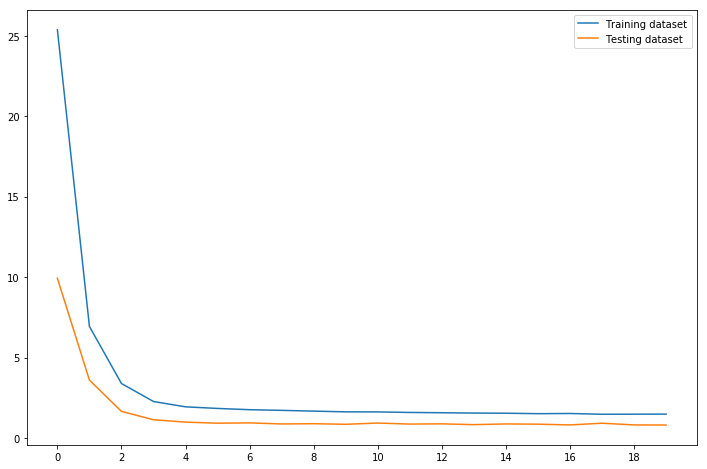

In [43]:
plt.figure(figsize = (12, 8))
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, 20, 2))
plt.show()

In [0]:
y_predicted_1 = model.predict(X_test)
y_predicted_1 = np.reshape(y_predicted_1, (y_predicted_1.size, ))

plt.figure(figsize = (16, 12))
plt.plot(y_test)
plt.plot(y_predicted_1)
plt.legend(["Real", "Predicted"])
plt.show()

## 2. LSTM

In [45]:
model = Sequential()

# 第一层
model.add(LSTM(
                    50, # 第一层的输出
                    input_shape = (None, 1), # 输入是一维度， 所以为1
                    return_sequences = False   # 最后一层用False
))  
model.add(Dropout(0.2))

# 第二层, 用Dense, 上一层的输出结果全部乘以一个矩阵， 最终得到一个数。
model.add(Dense(1)) # 期望输出的数的个数,我们的输出是一个数
model.add(Activation("linear"))
model.compile(loss = "mse", optimizer = "rmsprop") # 线性回归问题用 rmsprop
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [46]:
history_1 = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = 20, 
         validation_split = 0.05)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 39200 samples, validate on 2064 samples
Epoch 1/20
39200/39200 [==============================] - 9s 241us/step - loss: 26.0025 - val_loss: 9.5899
Epoch 2/20
39200/39200 [==============================] - 9s 224us/step - loss: 6.7858 - val_loss: 3.8098
Epoch 3/20
39200/39200 [==============================] - 9s 221us/step - loss: 3.3973 - val_loss: 1.8214
Epoch 4/20
39200/39200 [==============================] - 9s 221us/step - loss: 2.0201 - val_loss: 0.9950
Epoch 5/20
39200/39200 [==============================] - 9s 222us/step - loss: 1.5589 - val_loss: 0.8161
Epoch 6/20
39200/39200 [==============================] - 9s 225us/step - loss: 1.4597 - val_loss: 0.7784
Epoch 7/20
39200/39200 [==============================] - 9s 221us/step - loss: 1.4221 - val_loss: 0.7527
Epoch 8/20
39200/39200 [==============================] - 9s 221us/step - loss: 1.4039 - val_loss: 0.8325
Epoch 9/

In [47]:
min(history_2.history["val_loss"])

0.7297482287814451

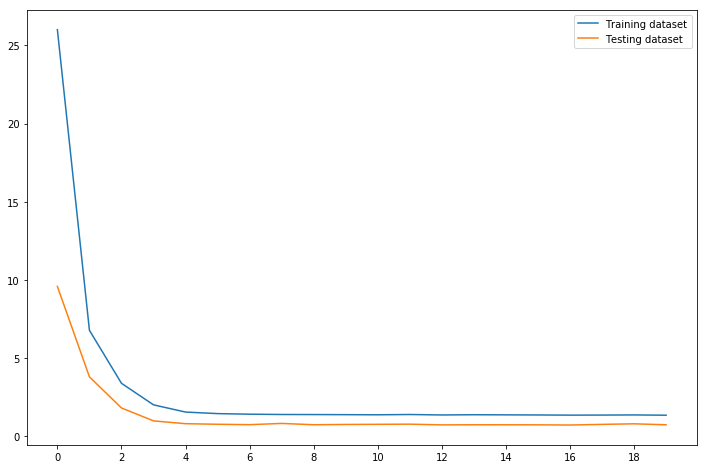

In [48]:
plt.figure(figsize = (12, 8))
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, 20, 2))
plt.show()

In [0]:
y_predicted_2 = model.predict(X_test)
y_predicted_2 = np.reshape(y_predicted_2, (y_predicted_2.size, ))

plt.figure(figsize = (16, 12))
plt.plot(y_test)
plt.plot(y_predicted_2)
plt.legend(["Real", "Predicted"])
plt.show()

## 3. 多层LSTM

In [52]:
model = Sequential()

# 第一层
model.add(LSTM(
        50, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(100,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))

start = time.time()
model.compile(loss = "mse", optimizer = "rmsprop")  # rmsprop 线性回归问题的标准做法， ADAM（）
print("Compilation Time:", time.time() - start)

Compilation Time: 0.0181734561920166


In [54]:
history_3 = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = 20, 
         validation_split = 0.05)

Train on 39200 samples, validate on 2064 samples
Epoch 1/20
39200/39200 [==============================] - 18s 447us/step - loss: 3.4267 - val_loss: 2.5298
Epoch 2/20
39200/39200 [==============================] - 18s 451us/step - loss: 2.0986 - val_loss: 1.3254
Epoch 3/20
39200/39200 [==============================] - 17s 444us/step - loss: 1.6951 - val_loss: 1.2085
Epoch 4/20
39200/39200 [==============================] - 17s 445us/step - loss: 1.5306 - val_loss: 0.8640
Epoch 5/20
39200/39200 [==============================] - 17s 444us/step - loss: 1.4604 - val_loss: 0.7914
Epoch 6/20
39200/39200 [==============================] - 18s 447us/step - loss: 1.3885 - val_loss: 0.8293
Epoch 7/20
39200/39200 [==============================] - 18s 448us/step - loss: 1.3670 - val_loss: 0.9598
Epoch 8/20
39200/39200 [==============================] - 17s 445us/step - loss: 1.3754 - val_loss: 0.9200
Epoch 9/20
39200/39200 [==============================] - 18s 447us/step - loss: 1.3354 - val_l

In [55]:
min(history_3.history["val_loss"])

0.7261295346037824

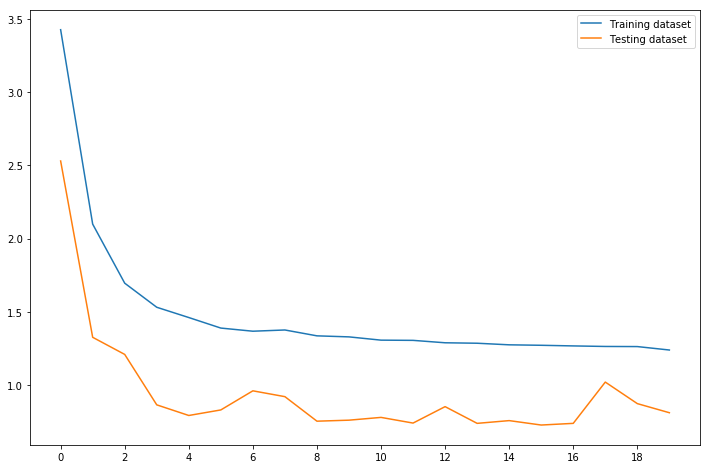

In [56]:
plt.figure(figsize = (12, 8))
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["Training dataset", "Testing dataset"])
plt.xticks(range(0, 20, 2))
plt.show()

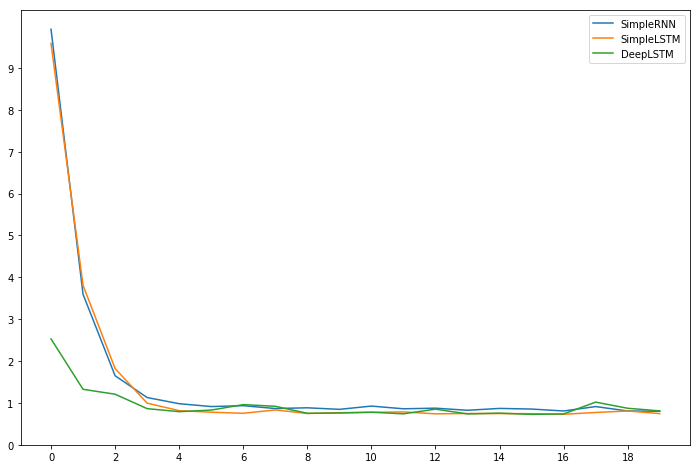

In [60]:
plt.figure(figsize = (12, 8))
plt.plot(history_1.history["val_loss"])
plt.plot(history_2.history["val_loss"])
plt.plot(history_3.history["val_loss"])
plt.legend(["SimpleRNN", "SimpleLSTM", "DeepLSTM"])
plt.xticks(range(0, 20, 2))
plt.yticks(range(0, 10, 1))
plt.show()

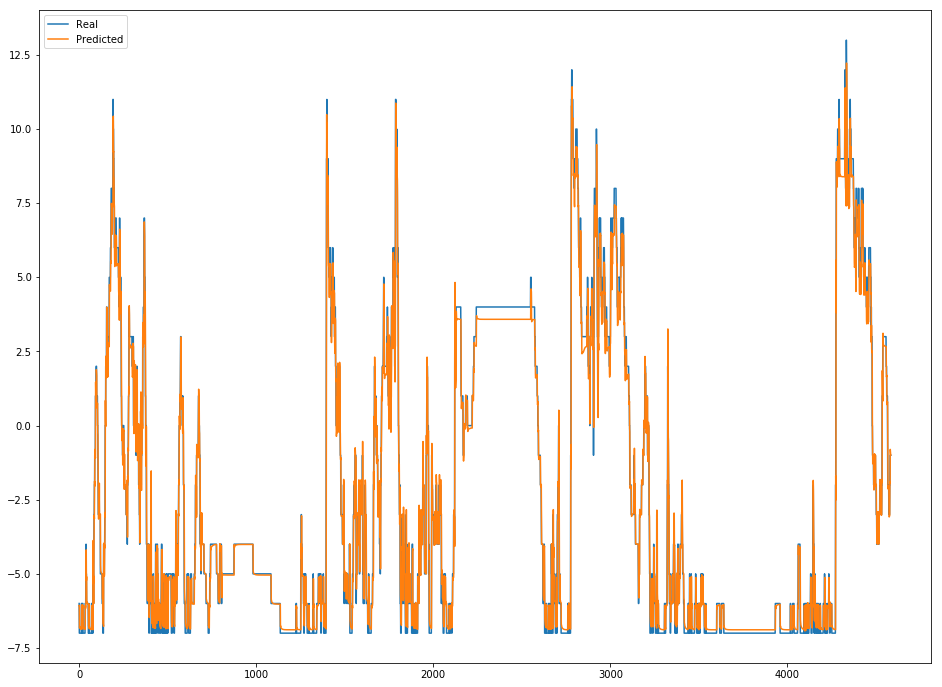

In [64]:
y_predicted_3 = model.predict(X_test)
y_predicted_3 = np.reshape(y_predicted_3, (y_predicted_3.size, ))

plt.figure(figsize = (16, 12))
plt.plot(y_test)
plt.plot(y_predicted_3)
plt.legend(["Real", "Predicted"])
plt.show()

##

In [0]:
model = Sequential()

# 第一层
model.add(LSTM(
        50, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层
model.add(LSTM(100,
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(1)) # 期望的输出个数是layers[3]
        
model.add(Activation("linear"))

start = time.time()
model.compile(loss = "mse", optimizer = adam(), metrics = ["mse"])  # rmsprop 线性回归问题的标准做法， ADAM（）
print("Compilation Time:", time.time() - start)

In [0]:
W = model.get_weights()[0]
U = model.get_weights()[1]
b = model.get_weights()[2]

def myRNN(n,X, W, U, b):
  "return Y"
  h = [[0], [0], [0]]
  Y = U * h + W * X + b
  return Y
  

In [0]:
h = np.array([[0], [0], [0]])
state = U.dot(h)

In [0]:
#W.dot(X)
X_ = X.reshape(X.shape[-1], 1)
prod = W.T.dot(X_)

In [0]:
b = model.get_weights()[2]

## self prediction

In [0]:
sequence_length = 99
auto_predict = [x for x in y_predicted]
for i in range(1000):
  temp = y_predicted[-99:]
  #print(temp)
  temp = np.reshape(temp, (1, 99, 1))
  res = model.predict(temp)
  auto_predict.append(res[0][0])
#auto_predict

In [0]:
auto_predicted = np.array(auto_predict)
auto_predicted = np.reshape(auto_predicted, (auto_predicted.size, ))

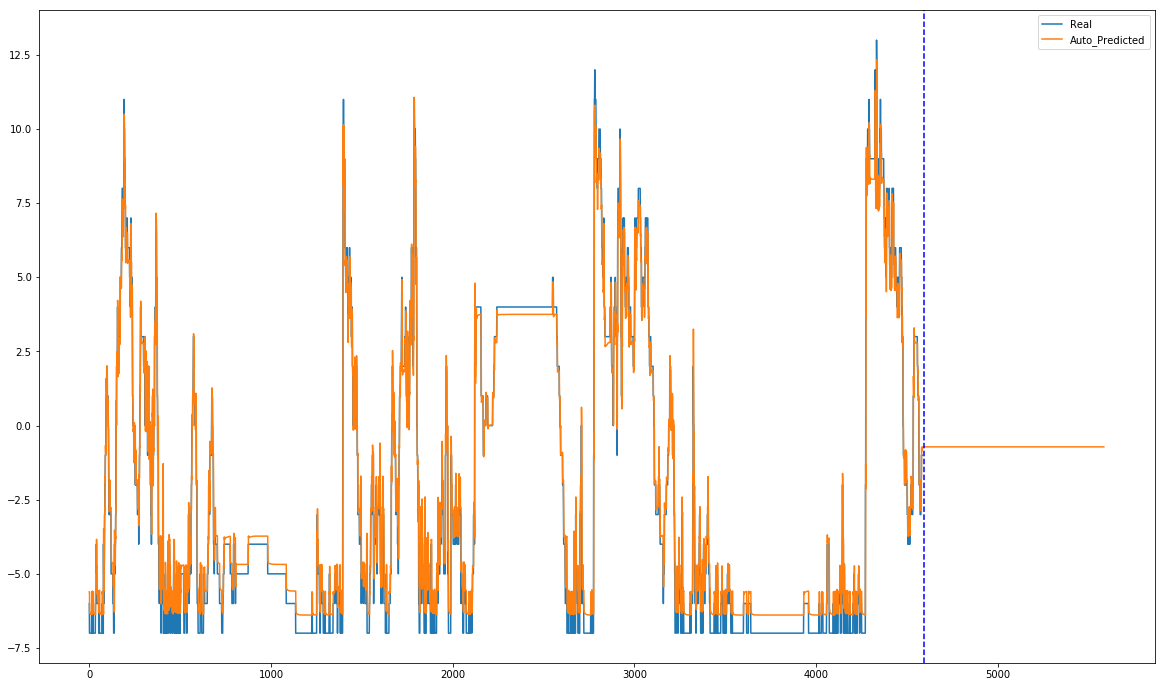

In [0]:
plt.figure(figsize = (20, 12))
plt.plot(y_test)
#plt.plot(y_predicted)
plt.plot(auto_predicted)
plt.legend(["Real", "Auto_Predicted"])
plt.axvline(x=4593, color='blue', linestyle='--')
plt.show()

Epoch 1/500
 - 0s - loss: 1.8355 - mean_squared_error: 1.8355 - mean_absolute_error: 1.2009 - mean_absolute_percentage_error: 218.3468 - cosine_proximity: 1.0000
Epoch 2/500
 - 0s - loss: 1.8215 - mean_squared_error: 1.8215 - mean_absolute_error: 1.1956 - mean_absolute_percentage_error: 217.0214 - cosine_proximity: 1.0000
Epoch 3/500
 - 0s - loss: 1.8075 - mean_squared_error: 1.8075 - mean_absolute_error: 1.1903 - mean_absolute_percentage_error: 215.6961 - cosine_proximity: 1.0000
Epoch 4/500
 - 0s - loss: 1.7936 - mean_squared_error: 1.7936 - mean_absolute_error: 1.1850 - mean_absolute_percentage_error: 214.3711 - cosine_proximity: 1.0000
Epoch 5/500
 - 0s - loss: 1.7797 - mean_squared_error: 1.7797 - mean_absolute_error: 1.1797 - mean_absolute_percentage_error: 213.0465 - cosine_proximity: 1.0000
Epoch 6/500
 - 0s - loss: 1.7659 - mean_squared_error: 1.7659 - mean_absolute_error: 1.1744 - mean_absolute_percentage_error: 211.7223 - cosine_proximity: 1.0000
Epoch 7/500
 - 0s - loss: 1.

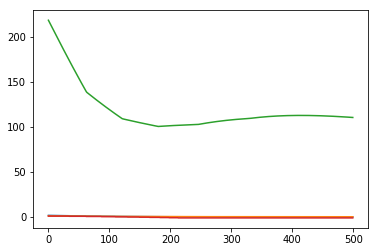

In [65]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# prepare sequence
X = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# create model
model = Sequential()
model.add(Dense(2, input_dim=1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
# train model
history = model.fit(X, X, epochs=500, batch_size=len(X), verbose=2)

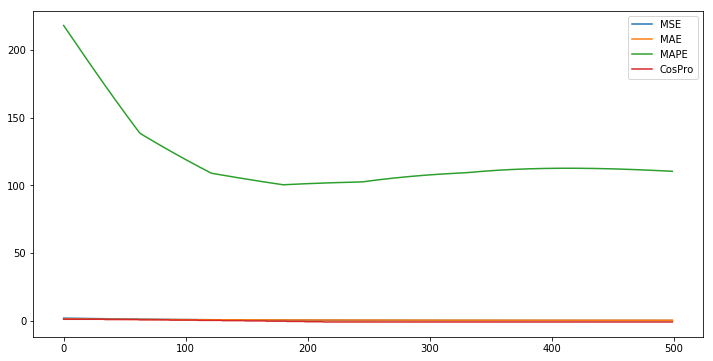

In [67]:
# plot metrics
plt.figure(figsize = (12, 6))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['cosine_proximity'])
plt.legend(["MSE", "MAE", "MAPE", "CosPro"])
pyplot.show()